## Social Media Analysis With Spark

 > Pada case ini akan dilakukan klasifikasi mengenai tweet yang berhasil dikumpulkan. Jumlah tweet yang terkumpul sebanyak 1.600.000 tweet. Pada dataset ini terdiri atas 2 features, yakni : <br>
- **Text** : Berisikan tweet yang berhasil dikumpulkan <br>
- **Target** : Merupakan sentimen dari masing-masing tweet. dimana target 0 menjelaskan bahwa data memiiki sentimen negatif, sedangkan target 1 menjelaskan bahwa data memiliki sentimen positif <br>

**Import Library dan Load Dataset**

In [1]:
import pandas as pd 
import numpy as np

#Authentication module. for documentation  (http://docs.tweepy.org)
import tweepy as tp

#import nltk module 
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

#import string, regex, , uniqcode
import re, string, unicodedata

import textblob 
from textblob import TextBlob

#visualization 
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline 
from wordcloud import WordCloud, STOPWORDS


#import sklearn preprocessing 
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

#import sklearn for modeling
from sklearn import svm
#from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

#import sklearn for model evaluation 
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_score, roc_auc_score


#import tqdm 
from tqdm import tqdm 
tqdm.pandas()

#import beaurtiful soup 
from bs4 import BeautifulSoup

#save model 
import pickle 

#textblob
from textblob import Word

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\devita064129\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
df=pd.read_csv('clean_tweet.csv')

In [3]:
df.head()

,text,target
0,awww that s a bummer you shoulda got david car...,0
1,is upset that he can t update his facebook by ...,0
2,i dived many times for the ball managed to sav...,0
3,my whole body feels itchy and like its on fire,0
4,no it s not behaving at all i m mad why am i h...,0


Selanjutnya adalah mengetahui tipe data dari dataframe yang digunakan, serta menemukan apakah ada data yang missing value atau tidak

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 2 columns):
text      1596753 non-null object
target    1600000 non-null int64
dtypes: int64(1), object(1)
memory usage: 24.4+ MB


Setelah melakukan load dataset diketahui bahwa **jumlah data 1.600.000**, namun terdapat missing value dari dataset tersebut. Sehingga perlu diidentifikasi lebih lanjut.

**Identifikasi Missing Value**

In [22]:
missing=df.isnull().sum().sort_values(ascending=False)
missing.head()

text      3247
target       0
dtype: int64

Ditemukan sebanyak 3247 data pada variabel text yang terdapat missing value

## Data Preprocessing

Preprocessing dilakukan sebelum melakukan analisis lebih lanjut. Tahapan preprocessing merupakan langkah krusial dalam pengelolahan data. Tahapan ini digunakan untuk mengurangi kemungkinan model gagal ketika dievaluasi. Preprocessing digunakan saat data yang digunakan kurang terstruktur serta melakukan seleksi terhadap variabel yang akan dianalisis. Pada case ini, tahap preprocessing dilakukan dengan beberapa step yakni :
- Lower Casing
- Punctuation Removal
- Stopwords Removal
- Spelling Correction
- Lemmatization

Sebelum dilakukan tahap preprocessing diatas, akan diselesaikan terlebih dahulu permasalahan missing value. Karena terdapat missing value sebanyak 3247 data, maka data missing value akan dihapus untuk memudahkan analisis selanjutnya.

In [23]:
df_new=df.dropna()

In [24]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1596753 entries, 0 to 1599999
Data columns (total 2 columns):
text      1596753 non-null object
target    1596753 non-null int64
dtypes: int64(1), object(1)
memory usage: 36.5+ MB


In [25]:
missing1=df_new.isnull().sum().sort_values(ascending=False)
missing1.head()

target    0
text      0
dtype: int64

Setelah dilakukan penghapusan data yang missing, selanjutnya dilakukan pengecekan kembali dan tidak ditemukan adanya missing value sehingga dapat dilanjutkan ke step berikutnya.

### 1. Lower Casing

Telah dijelaskan diatas bahwa dataset yang digunakan merupakan dataset mengenai tweet dari masing-masing user. Dalam menulis tweet sering dijumpai penggunaan huruf kapital, baik diawal, ditengah maupun diakhir kalimat. Untuk melakukan analisis terhadap data tweet, perlu dilakukan penyeragaman tweet agar huruf yang digunakan hanyalah huruf kecil tanpa huruf kapital menggunakan **Lower casing.**

In [26]:
df_new['text'] = df_new['text'].apply(lambda x: " ".join(x.lower() for x in x.split()))
df_new['text'].head()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


0    awww that s a bummer you shoulda got david car...
1    is upset that he can t update his facebook by ...
2    i dived many times for the ball managed to sav...
3       my whole body feels itchy and like its on fire
4    no it s not behaving at all i m mad why am i h...
Name: text, dtype: object

### 2. Punctuation Removal

Setelah dilakukan penyeragaman huruf pada masing-masing kata dari tweet yang telah terkumpul, selanjutnya adalah melakukan penghapusan tanda baca dari masing-masing tweet. Penghapusan ini digunakan untuk membantu sebelum melakukan sentimen analisis dikarenakan tanda baca umumnya tidak mencerminkan sentimen positif serta negatif.

In [27]:
df_new['text'] = df_new['text'].str.replace('[^\w\s]','')
df_new.head()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,text,target
0,awww that s a bummer you shoulda got david car...,0
1,is upset that he can t update his facebook by ...,0
2,i dived many times for the ball managed to sav...,0
3,my whole body feels itchy and like its on fire,0
4,no it s not behaving at all i m mad why am i h...,0


### 3. Stopwords removal

Stopword merupakan kata-kata umum yang tidak memiliki makna. Untuk mempermudah melakukan analisis sentimen, maka dilakukan penghapusan terhadap kata hubung dan kata-kata yang tidak memiliki makna. Selain itu, pada tahap stopwords removal ini akan dilakukan pengelompokkan kata-kata yang sering digunakan kedalam sekelompok kata yang memiliki arti yang serupa.

In [28]:
stop = stopwords.words('english')
df_new['text'] = df_new['text'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
df_new['text'].head(10)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


0         awww bummer shoulda got david carr third day
1    upset update facebook texting might cry result...
2    dived many times ball managed save rest go bounds
3                     whole body feels itchy like fire
4                                     behaving mad see
5                                           whole crew
6                                             need hug
7    hey long time see yes rains bit bit lol fine t...
8                                               k nope
9                                            que muera
Name: text, dtype: object

### 4. Spelling correction

Pada pengguna twitter terkadang melakukan kesalahan penulisan saat menulis suatu tweet baik disengaja maupun tidak. Pada step ini akan dilakukan perbaikan kesalahan penulisan pada tweet untuk memudahkan dalam analisis sentimen.

In [29]:
df_new['text'][:5].apply(lambda x: str(TextBlob(x).correct()))

0           www summer should got david care third day
1    upset update facebook testing might cry result...
2    dived many times ball managed save rest go bounds
3                     whole body feels itchy like fire
4                                     behaving mad see
Name: text, dtype: object

### 5. Lematization

Lematization merupakan proses mengubah kata berimbuhan menjadi kata dasar. Lematization digunakan untuk mengubah ejaan kata agar sesuai dengan kamus

In [34]:
from textblob import Word
df_new['text'] = df_new['text'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))
df_new['text'].head()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


0         awww bummer shoulda got david carr third day
1    upset update facebook texting might cry result...
2      dived many time ball managed save rest go bound
3                      whole body feel itchy like fire
4                                     behaving mad see
Name: text, dtype: object

In [35]:
df_new.head()

,text,target
0,awww bummer shoulda got david carr third day,0
1,upset update facebook texting might cry result...,0
2,dived many time ball managed save rest go bound,0
3,whole body feel itchy like fire,0
4,behaving mad see,0


## Wordcloud

Word Cloud adalah gambar yang terbuat dari kata-kata yang bersama-sama menyerupai bentuk berawan. Ukuran kata menunjukkan betapa pentingnya kata itu, mis. seberapa sering muncul dalam teks - frekuensinya. Sehingga pada project ini, wordcloud digunakan untuk mengetahui kata-kata yang sering muncul baik dari keseluruhan sentimen, sentimen negatif maupun sentimen positif.

### Wordcloud Keseluruhan Sentimen

Pada wordcloud ini, akan dilakukan analisis menggunakan keseluruhan data untuk mengetahui data yang sering muncul pada tweet yang telah berhasil dikumpulkan.

In [36]:
wordc = ''.join(df_new.text.values)

In [37]:
def create_word_cloud(string):
    cloud = WordCloud(background_color = "black", 
                      max_words = 200, 
                      stopwords = set(STOPWORDS)
                     ).generate(string)
    plt.figure(1,figsize=(12, 12))
    plt.imshow(cloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

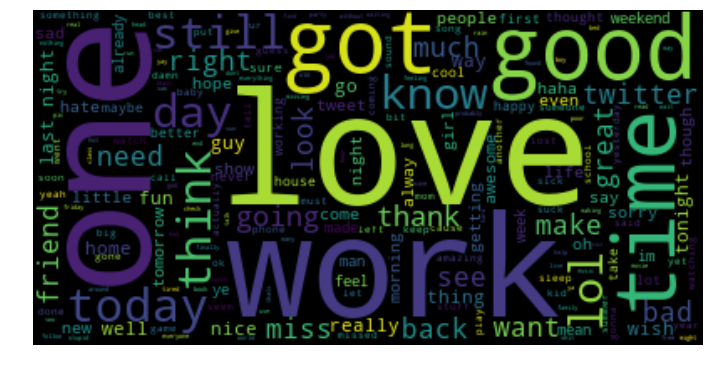

In [38]:
create_word_cloud(wordc)

Dapat diketahui bahwa dari keseluruhan tweet, lima kata yang sering muncul :
- love
- work
- one
- got
- good

### Wordcloud Sentiment Negatif

Pada wordcloud ini, akan dilakukan analisis menggunakan data pada variabel text yang memiliki kode target =0 yang menunjukkan bahwa tweet tersebut memiliki sentimen negatif.

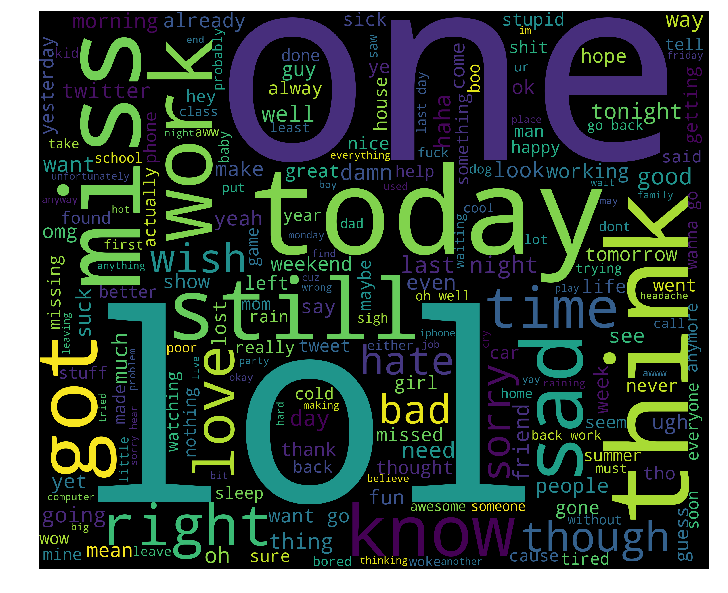

In [39]:
negative=df_new[df_new['target']==0]
words = ' '.join(negative['text'])
cleaned_word = " ".join([word for word in words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and word != 'RT'
                            ])
wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color='black',
                      width=3000,
                      height=2500
                     ).generate(cleaned_word)
plt.figure(1,figsize=(12, 12))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

Dapat diketahui bahwa dari keseluruhan tweet, lima kata yang sering muncul :
- One
- Lol
- Today
- Think
- Miss

### Wordcloud Sentiment Positif

Pada wordcloud ini, akan dilakukan analisis menggunakan data pada variabel text yang memiliki kode target = 1 yang menunjukkan bahwa tweet tersebut memiliki sentimen positif.

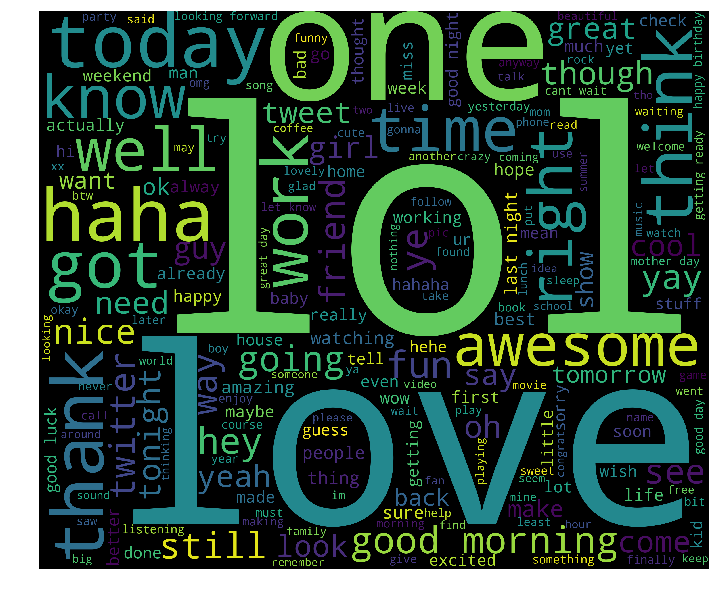

In [43]:
positive=df_new[df_new['target']==1]
words = ' '.join(positive['text'])
cleaned_word = " ".join([word for word in words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and word != 'RT'
                            ])
wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color='black',
                      width=3000,
                      height=2500
                     ).generate(cleaned_word)
plt.figure(1,figsize=(12, 12))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

### Feature Extraction

Feature extraction merupakan proses transformasi dari data original ke dataset sehingga membentuk pola tertentu. Pola ini yang diharapkan dapat membantu analisis lebih lanjut terhadap data yang akan digunakan.Pada project ini menggunakan dua feature extraction yakni :
1. Count Vectorizer
2. TF IDF

### Count Vectorizer

Merupakan perhitungan semua kata yang digunakan untuk selanjutnya dijadikan representasi dari dataset tersebut. Dikarenakan data telah memiliki tipe integer maka tidak perlu dilakukan tahap preprocessing kembali untuk mengubah tipe data.

In [41]:
count_vec=CountVectorizer(stop_words='english')

### TF - IDF

Merupakan salah satu algoritma yang dapat digunakan untuk menganalisa hubungan antara sebuah frase/kalimat dengan sekumpulan dokumen. Pada project ini, TF-IDF digunakan untuk memberi bobot antar kata dari keseluruhan data tweet yang telah berhasil dikumpulkan.

In [48]:
tfidf=TfidfVectorizer(stop_words='english')

Setelah dilakukan feature extraction, dalam melakukan pemodelan umumnya menggunakan variabel X sebagai variabel prediktor dan Y sebagai variabel respon sehingga pada step ini dilakukan pembagian pada masing-masing variabel.

In [45]:
X = df_new['text']
y = df_new['target']

In [49]:
#countvectorizer
X_vectorizer = count_vec.fit_transform(X)

#tfidf vectorizer
X_tfidf = tfidf.fit_transform(X)

**Split data training dan data testing**

Dalam melakukan modelling, untuk melakukan evaluasi kebaikan model umumnya menggunakan data testing, sehingga perlu dilakukan pembagian data menjadi data training dan data testing dari masing-masing variabel prediktor dan respon dengan proporsi pembagian 80:20

In [51]:
#train test split using countvectorizer 
train_X_vec, test_X_vec, train_y, test_y = train_test_split(X_vectorizer, y, test_size=0.2, random_state=0)

#train test split using tfidfvectorizer 
train_X_tfidf, test_X_tfidf, train_y, test_y = train_test_split(X_tfidf, y, test_size=0.2, random_state=0)

## Modelling

Sosial media seperti twitter berisi konten yang dibuat oleh pengguna sosial media tersebut. Konten tersebut berupa data yang dapat dianalisa  yang terjadi pada sosial media tersebut. Secara umum, terdapat 2 pendekatan untuk melakukan Sentiment Analysis, salah satunya pendekatan menggunakan Machine Learning. Pada project ini, akan dilakukan pemodelan dengan menggunakan metode :

**1. Naive Bayes** <br>
Naive bayes merupakan algoritma klasifikasi dengan menggunakan metode probabiliats dan statistik. Naive bayes digunakan untuk memprediksi peluang dimasa depan berdasarkan pengalaman di masa sebelumnya. <br>
**2. Regresi Logistik** <br>
Regresi logistik merupakan pendekatan untuk membangun suatu model prediksi dengan skala dikotomi dimana skala dikotomi merupakan skala data dengan dua kategori.

### Model Evaluation

Setelah dilakukan pemodelan dengan menggunakan sistem klasifikasi, perlu dianalisis seberapa baik kinerja metode pemodelan yang digunakan dalam mengklasifikasi data. Pada case ini, metode evaluasi yang digunakan adalah :
- **Akurasi** <br>
Akurasi merupakan perbandingan antara data yang terklasifikasi benar dengan keseluruhan data. 
- **Presisi** <br>
Presisi menggambarkan jumlah data dengan kategori positif yang diklasifikasikan secara benar dengan total data yang memiliki klasifikasi positif.
- **AUC** <br>
Auc merupakan daerah dibawah garis kurva dimana hal ini menggambarkan keseluruhan pengukuran atas kesuaian model yang digunakan.

### 1.  Naive Bayes

In [54]:
# Countvectorizer
NB_vect = MultinomialNB()
NB_vect.fit(train_X_vec,train_y)
NB_pred_vect_train = NB_vect.predict(train_X_vec)
NB_pred_vect_test = NB_vect.predict(test_X_vec)
NB_pred_vect_test

array([0, 0, 0, ..., 1, 0, 1], dtype=int64)

In [55]:
# TFIDFVectorizer
#from sklearn.naive_bayes import GaussianNB
NB_tfidf = MultinomialNB()
NB_tfidf.fit(train_X_tfidf,train_y)
NB_pred_tfidf_train = NB_tfidf.predict(train_X_tfidf)
NB_pred_tfidf_test = NB_tfidf.predict(test_X_tfidf)
NB_pred_tfidf_test

array([0, 0, 0, ..., 1, 0, 1], dtype=int64)

In [76]:
# find model evaluation for naive bayes
# using count vectorizer
print("______________ Countvectorizer ______________")

NB_akurasi_vec_train = NB_vect.score(train_X_vec,train_y)
NB_akurasi_vec_test = NB_vect.score(test_X_vec,test_y)

NB_precision_vec_train = precision_score(train_y, NB_pred_vect_train,average="micro")
NB_precision_vec_test = precision_score(test_y, NB_pred_vect_test,average="micro")

NB_AUC_vec = roc_auc_score(test_y,NB_pred_vect_test)

print('Information :')
print('Akurasi train & test  : %.2f%%' % (NB_akurasi_vec_train * 100), '&', '%.2f%%' % (NB_akurasi_vec_test * 100))
print('Presisi train & test  : %.2f%%' % (NB_precision_vec_train * 100), '&', '%.2f%%' % (NB_precision_vec_test * 100))
print('AUC Score             : %.2f%%' % (NB_AUC_vec * 100))

______________ Countvectorizer ______________
Information :
Akurasi train & test  : 79.08% & 76.20%
Presisi train & test  : 79.08% & 76.20%
AUC Score             : 76.20%


In [79]:
# using count vectorizer
print("______________ TF-IDF ______________")

NB_akurasi_tfidf_train = NB_tfidf.score(train_X_vec,train_y)
NB_akurasi_tfidf_test = NB_tfidf.score(test_X_vec,test_y)

NB_precision_tfidf_train = precision_score(train_y, NB_pred_tfidf_train,average="micro")
NB_precision_tfidf_test = precision_score(test_y, NB_pred_tfidf_test,average="micro")

NB_AUC_tfidf = roc_auc_score(test_y,NB_pred_tfidf_test)

print('Information :')
print('Akurasi train & test    : %.2f%%' % (NB_akurasi_tfidf_train * 100), '&', '%.2f%%' % (NB_akurasi_tfidf_test * 100))
print('Precision train & test  : %.2f%%' % (NB_precision_tfidf_train * 100), '&', '%.2f%%' % (NB_precision_tfidf_test * 100))
print('AUC Score               : %.2f%%' % (NB_AUC_tfidf * 100))

______________ TF-IDF ______________
Information :
Akurasi train & test    : 78.71% & 76.36%
Precision train & test  : 79.12% & 75.62%
AUC Score               : 75.62%


### 2.  Logistic Regression

In [80]:
# Countvectorizer 
Lr_vect = LogisticRegression()
Lr_vect.fit(train_X_vec,train_y)
Lr_pred_vect_train = Lr_vect.predict(train_X_vec)
Lr_pred_vect_test = Lr_vect.predict(test_X_vec)

array([0, 0, 0, ..., 1, 0, 1], dtype=int64)

In [82]:
# TFIDFVectorizer
Lr_tfidf = LogisticRegression()
Lr_tfidf.fit(train_X_tfidf,train_y)
Lr_pred_tfidf_train = Lr_tfidf.predict(train_X_tfidf)
Lr_pred_tfidf_test = Lr_tfidf.predict(test_X_tfidf)

array([0, 0, 0, ..., 1, 0, 1], dtype=int64)

In [84]:
# using count vectorizer
print("______________ Countvectorizer ______________")

Lr_akurasi_vec_train = Lr_vect.score(train_X_tfidf,train_y)
Lr_akurasi_vec_test = Lr_vect.score(test_X_tfidf,test_y)

Lr_precision_vec_train = precision_score(train_y, Lr_pred_vect_train,average="micro")
Lr_precision_vec_test = precision_score(test_y, Lr_pred_vect_test,average="micro")

Lr_AUC_vec = roc_auc_score(test_y,Lr_pred_vect_test)

print('Information :')
print('Akurasi train & test     : %.2f%%' % (Lr_akurasi_vec_train * 100), '&', '%.2f%%' % (Lr_akurasi_vec_test * 100))
print('Presisi train & test     : %.2f%%' % (Lr_precision_vec_train * 100), '&', '%.2f%%' % (Lr_precision_vec_test * 100))
print('AUC Score                : %.2f%%' % (Lr_AUC_vec * 100))

______________ Countvectorizer ______________
Information :
Akurasi train & test     : 79.94% & 75.41%
Presisi train & test     : 80.25% & 76.98%
AUC Score                : 76.99%


In [85]:
# using count vectorizer
print("______________ TF-IDF ______________")

Lr_akurasi_tfidf_train = Lr_tfidf.score(train_X_vec,train_y)
Lr_akurasi_tfidf_test = Lr_tfidf.score(test_X_vec,test_y)

Lr_precision_tfidf_train = precision_score(train_y, Lr_pred_tfidf_train,average="micro")
Lr_precision_tfidf_test = precision_score(test_y, Lr_pred_tfidf_test,average="micro")

Lr_AUC_tfidf = roc_auc_score(test_y,Lr_pred_tfidf_test)

print('Information :')
print('Akurasi train & test    : %.2f%%' % (Lr_akurasi_tfidf_train * 100), '&', '%.2f%%' % (Lr_akurasi_tfidf_test * 100))
print('Precision train & test  : %.2f%%' % (Lr_precision_tfidf_train * 100), '&', '%.2f%%' % (Lr_precision_tfidf_test * 100))
print('AUC Score               : %.2f%%' % (Lr_AUC_tfidf * 100))

______________ TF-IDF ______________
Information :
Akurasi train & test    : 78.37% & 76.78%
Precision train & test  : 79.48% & 77.12%
AUC Score               : 77.12%


Berdasarkan analisis menggunakan metode Naive Bayes dan Regresi Logistik, didapatkan nilai evaluasi meliputi akurasi, presisi, dan AUC. Jika dibandingkan dari nilai evaluasi, **pada data testing paling tinggi adalah metode Regresi Logistik dengan nilai Presisi dan AUC sebesar 77,12%**.